In [2]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
%matplotlib qt

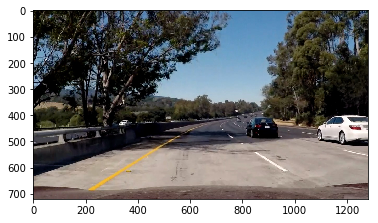

In [3]:
im = mpimg.imread('test_images/test5.jpg')
plt.imshow(im)  

## Lets Calibarate Camera

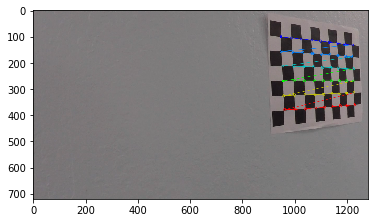

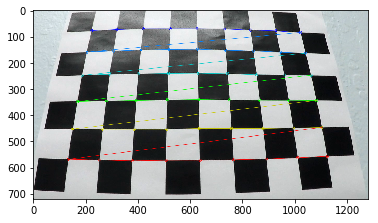

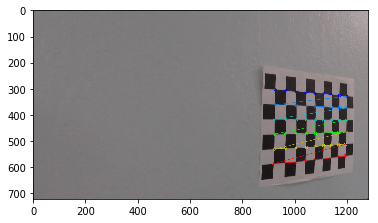

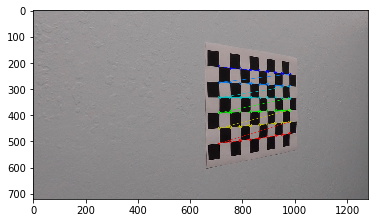

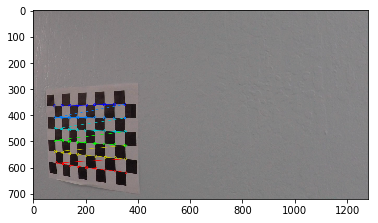

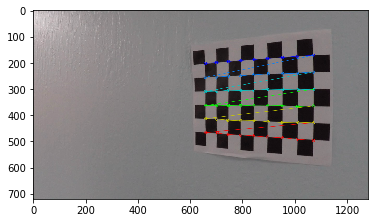

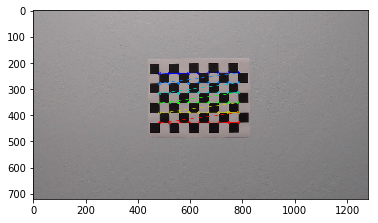

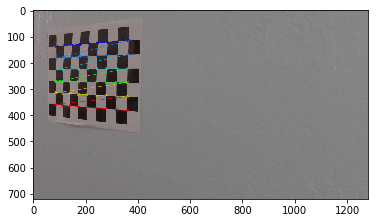

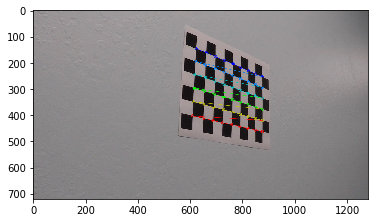

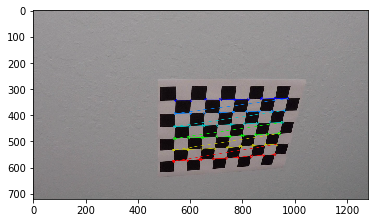

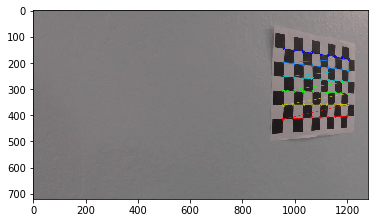

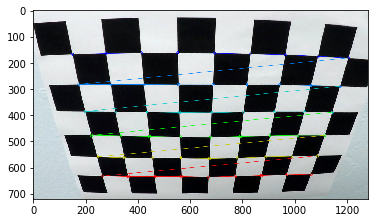

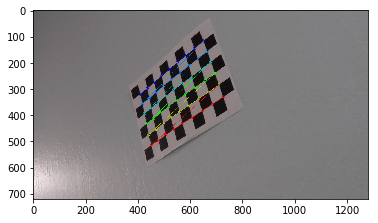

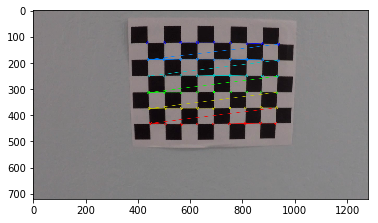

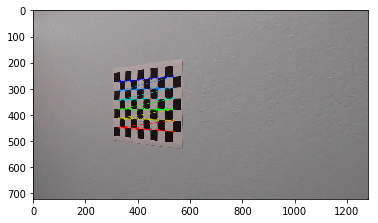

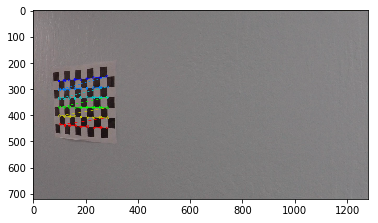

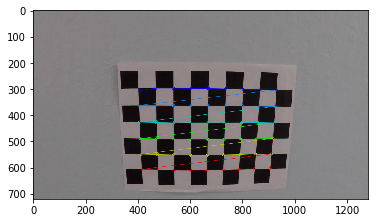

In [4]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img, cmap='gray')
        plt.show()

#cv2.destroyAllWindows()

## Now, Undistort Images from test_image

Undistorted pictures


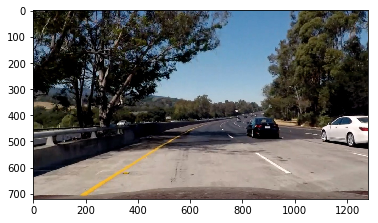

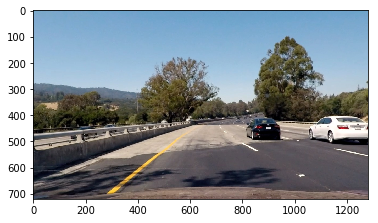

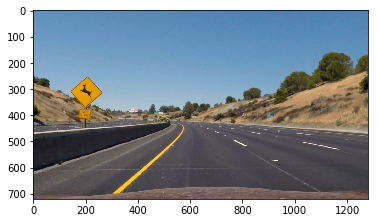

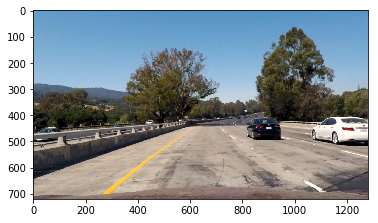

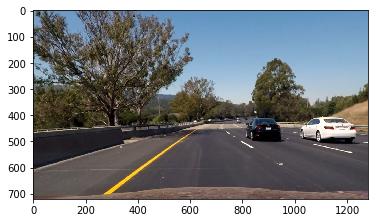

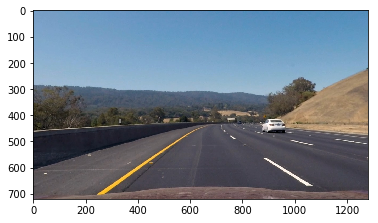

In [6]:
undist_array = []

def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

test_images = glob.glob('test_images/test*.jpg')


for fname in test_images:
    img = mpimg.imread(fname)
    undistorted = undistort(img, objpoints, imgpoints)
    undist_array.append(undistorted)
    plt.figure()
    plt.imshow(undistorted)

print('Undistorted pictures')

## Lets apply threshold on undistorted pictures to get binary images, Apply color along with Sobel gradient threshold and then resultant would be a combined binary image

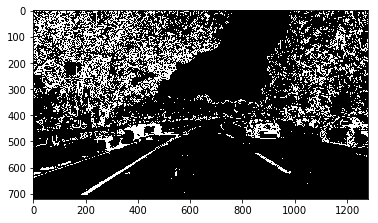

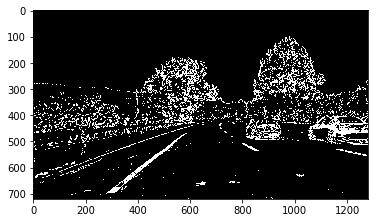

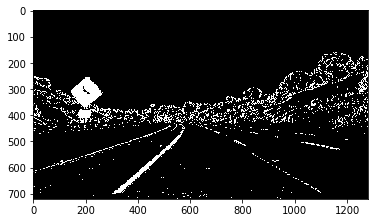

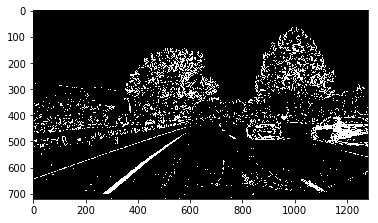

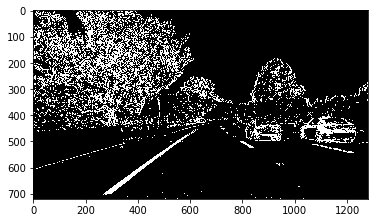

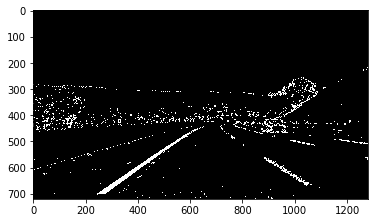

In [7]:
img_arr = []

for img in undist_array:
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    min_thresh = 20
    max_thresh = 110
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    s_min_thresh = 160
    s_max_thresh = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_min_thresh) & (s_channel <= s_max_thresh)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    res_bin = np.zeros_like(sxbinary)
    res_bin[(s_binary == 1) | (sxbinary == 1)] = 1
    img_arr.append(res_bin)
    plt.figure()
    plt.imshow(res_bin, cmap='gray')

## Lets find coordinates of corners of our rectangle for perspective transform, src and dest will be identified and using this perspective transform T and inverse perspective invT will be computed

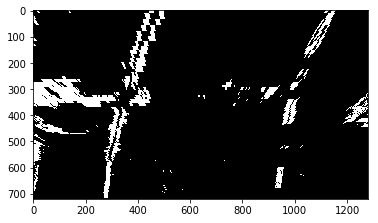

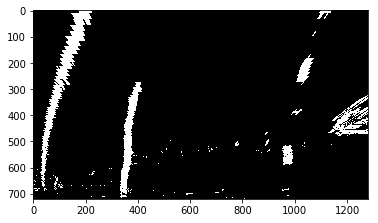

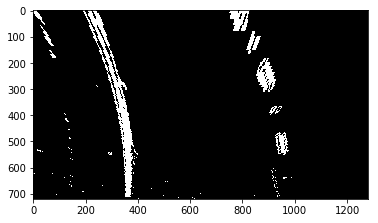

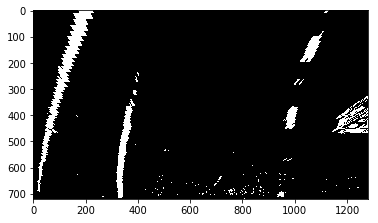

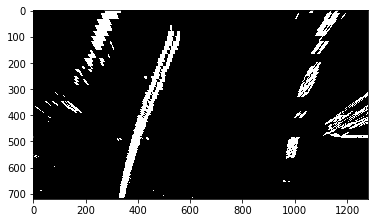

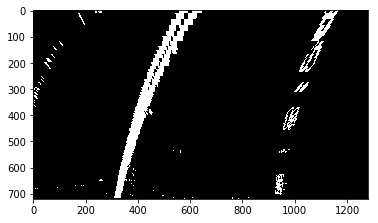

In [8]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

img_sz = (img.shape[1], img.shape[0])
src = np.float32([[588,450],[683,450],[1090,720],[200,720]])
dest = np.float32([[300,0],[900,0],[900,720],[300,720]])
T = cv2.getPerspectiveTransform(src, dest)
invT = cv2.getPerspectiveTransform(dest, src)

def warp_image(img, src, dest):
    # Compute and apply perpective transform
    im_sz = (img.shape[1], img.shape[0])
    T = cv2.getPerspectiveTransform(src, dest)
    warped_img = cv2.warpPerspective(img, T, im_sz, flags=cv2.INTER_NEAREST)
    return warped_img

warped_imgs_arr = []
for img in img_arr:
    warped_image = warp_image(img, src, dest)
    plt.figure()
    plt.imshow(warped_image, cmap='gray')
    warped_imgs_arr.append(warped_image)

## Now, Lets find all lane pixels and fit a polynomial using sliding window

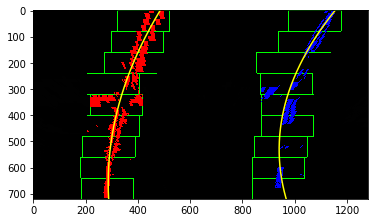

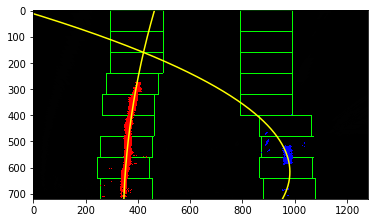

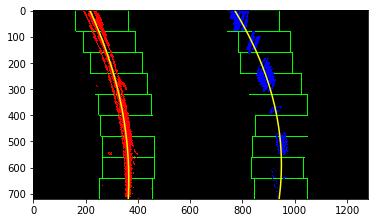

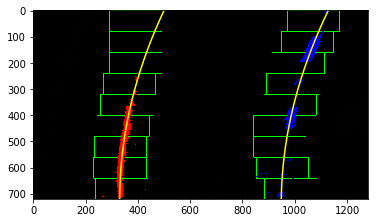

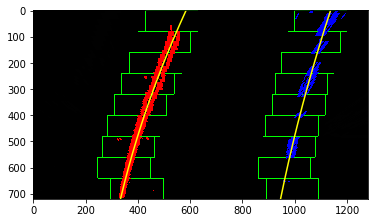

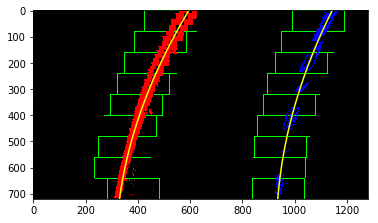

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


for img in warped_imgs_arr:
    res_img = fit_polynomial(img)
    plt.imshow(res_img)
    plt.figure()

## Finding the lines : Search from Prior

Curvature: 983.01 m
Center offset: 0.15 m
Curvature: 859.51 m
Center offset: 0.05 m
Curvature: 419.14 m
Center offset: 0.04 m
Curvature: 525.86 m
Center offset: 0.01 m
Curvature: 1820.33 m
Center offset: 0.00 m
Curvature: 773.65 m
Center offset: 0.06 m


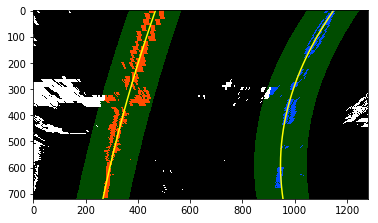

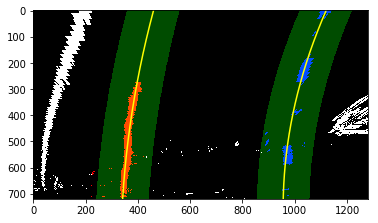

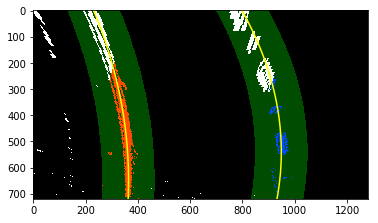

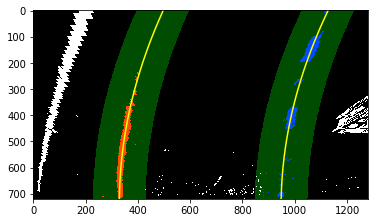

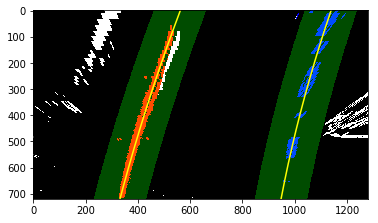

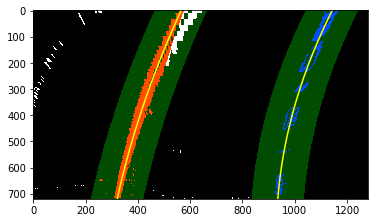

In [15]:
def measure_curvature_real(x_values, warped_img):   
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    yrange = warped_img.shape[0]
    y_points = np.linspace(0, yrange-1, yrange)
    y_eval = np.max(y_points)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    radius_curve = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return radius_curve

lane_img_arr = []

left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    left_curve_radius = measure_curvature_real(left_fitx, binary_warped)
    right_curve_radius = measure_curvature_real(right_fitx, binary_warped)
    average_curve_radius = (left_curve_radius + right_curve_radius)/2
    curv = "Curvature: %.2f m" % average_curve_radius
    print(curv)
    
    road_center = (right_fitx[719] + left_fitx[719])/2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center_offset_pixels = abs(img_sz[0]/2 - road_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    offset = "Center offset: %.2f m" % center_offset_meters
    print(offset)
    
   
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result


# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
for img in warped_imgs_arr:
    res_img = search_around_poly(img)
    lane_img_arr.append(res_img)
    plt.imshow(res_img)
    plt.figure()


## Lets paint lane area over result image


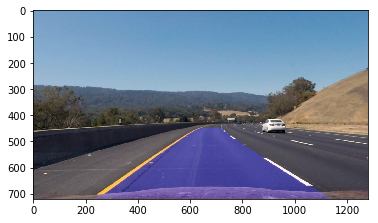

In [16]:
for img in warped_imgs_arr:   
    margin = 100   
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])   
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))   
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)   
    warp_zero = np.zeros_like(img).astype(np.uint8)
    colored_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((left_points, right_points))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(colored_warp, np.int_([points]), (0,0, 255))

    #Now use invT
    invT_warped_img = cv2.warpPerspective(colored_warp, invT, img_sz) 
    # Combine the result with the original image
    res_img = cv2.addWeighted(undistorted, 1, invT_warped_img, 0.3, 0)
    plt.imshow(res_img)


In [17]:
def curvature_and_centre_offset(img):
    margin = 100
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
    left_curve_radius = measure_curvature_real(left_fitx, img)
    right_curve_radius = measure_curvature_real(right_fitx, img)
    average_curve_radius = (left_curve_radius + right_curve_radius)/2
    curvature = "Curvature: %.2f m" % average_curve_radius
    
    road_center = (right_fitx[719] + left_fitx[719])/2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center_offset_pixels = abs(img_sz[0]/2 - road_center)
    center_offset_meters = xm_per_pix*center_offset_pixels
    offset = "Offset: %.2f m" % center_offset_meters
    return curvature, offset

## Advanced Lane Finding Pipeline

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(img):
    original_img = np.copy(img)
    undistorted = undistort(original_img, objpoints, imgpoints)
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    min_thresh = 20
    max_thresh = 110
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    s_min_thresh = 160
    s_max_thresh = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_min_thresh) & (s_channel <= s_max_thresh)] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    res_binary = np.zeros_like(sxbinary)
    res_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    warped_image = warp_image(res_binary, src, dest)
    curvature, offset = curvature_and_centre_offset(warped_image)
    margin = 100
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, leftx, lefty, rightx, righty)
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    colored_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    left_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((left_points, right_points))
    cv2.fillPoly(colored_warp, np.int_([points]), (255,0, 0))
    invT_warped_img = cv2.warpPerspective(colored_warp, invT, img_sz) 
    res_final = cv2.addWeighted(undistorted, 1, invT_warped_img, 0.3, 0)
    cv2.putText(res_final,curvature , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255,255,255), thickness=5)
    cv2.putText(res_final, offset, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.7, (255,255,255), thickness=5)
    
    return res_final

In [21]:
white_output = 'video_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video video_output/project_video_output.mp4
[MoviePy] Writing video video_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [12:09<00:00,  1.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video_output.mp4 

CPU times: user 9min 47s, sys: 3.08 s, total: 9min 50s
Wall time: 12min 12s
